In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from pytorch_pretrained_vit import ViT
import random
import warnings
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedShuffleSplit
from collections import Counter
import sklearn

In [2]:
#hyper params
lr = 1e-5
wd = 1e-2
feature_extract = True
#lr = 1e-4
bs = 8
test_size = 0.15  # Test set size (20%)
val_size = 0.2   # Validation set size (25%)
num_epoch = 40
classes = ['irrelevant','relevant'] #arranged in order of their placement in the folder
num_classes = len(classes)
path = 'Balanced_Binary_Dataset'
hardness_threshold = 0.75
lambda_u = 0.1  # Weighting factor for the unsupervised loss


In [3]:

def get_dataset(path,val_split,test_split):
    transform_weak = transforms.Compose([transforms.Resize((256,256)),
                                         transforms.ToTensor(),
                                         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                                               ])

    transform_strong = transforms.Compose([
                                        transforms.Resize((256, 256)),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.RandomRotation(degrees=10),
                                        transforms.RandomCrop(size=256),
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
                                        transforms.ToTensor(),
                                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                        ])


    dataset_strong = datasets.ImageFolder(path,transform=transform_strong)
    dataset_weak = datasets.ImageFolder(path,transform=transform_weak)

    trainset_strong,valset_strong,testset_strong = stratified(dataset_strong)
    trainset_weak,valset_weak,testset_weak = stratified(dataset_weak)
    
    print("train strong:",len(trainset_strong),"val strong:",len(valset_strong),"test strong:",len(testset_strong))
    print("train weak:",len(trainset_weak),"val weak:",len(valset_weak),"test strong:",len(testset_weak))

    
    return trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak

In [4]:
def stratified(dataset):
    # Get the labels and targets from the dataset
    labels = [label for _, label in dataset.samples]
    targets = dataset.targets

    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    train_val_indices, test_indices = next(stratified_split.split(targets, labels))

    train_val_dataset = torch.utils.data.Subset(dataset, train_val_indices)
    testset = torch.utils.data.Subset(dataset, test_indices)
    
    # Further split the train-val dataset into train and validation sets
    stratified_split = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=42)
    train_indices, val_indices = next(stratified_split.split(train_val_dataset, [labels[idx] for idx in train_val_indices]))

    trainset = torch.utils.data.Subset(train_val_dataset, train_indices)
    valset = torch.utils.data.Subset(train_val_dataset, val_indices)
    
    return trainset,valset,testset

In [5]:
def train_model(trainset_strong, valset_strong, trainset_weak,valset_weak, model, criterion, optimizer, scheduler, num_epochs, bs, hardness_threshold):
    dataloaders_strong = {
        'train': data.DataLoader(trainset_strong, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_strong, batch_size=bs, shuffle=True)
    }

    dataloaders_weak = {
        'train': data.DataLoader(trainset_weak, batch_size=bs, shuffle=True),
        'val': data.DataLoader(valset_weak, batch_size=bs, shuffle=True)
    }
    dataset_sizes_strong = {'train': len(trainset_strong), 'val': len(valset_strong)}
    dataset_sizes_weak = {'train': len(trainset_weak), 'val': len(valset_weak)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Lists to store entropy values for each epoch
    entropy_values_train = []
    entropy_values_val = []
    # Lists to store loss of each epoch
    E_loss_train = []
    E_loss_val = []
    # Lists to store balanced accuracy for training and validation phases
    balanced_acc_train = []
    balanced_acc_val = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            all_labels = []
            all_preds = []
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                        
            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy

            # Iterate over data.
            for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloaders_strong[phase],dataloaders_weak[phase]):
                inputs_strong = inputs_strong.to(device)
                inputs_weak = inputs_weak.to(device)                
                labels_weak = labels_weak.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs_weak = model(inputs_weak)
                    _, preds_weak = torch.max(outputs_weak, 1)

                    #loss = criterion(outputs_weak, labels_weak)



                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs_weak, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]

                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    
                    
                    if skip_mask.sum().item() > 0:
                        c += 1
                        inputs_weak = inputs_weak[skip_mask]
                        labels_weak = labels_weak[skip_mask]
                        preds_weak = preds_weak[skip_mask]
                        #loss = criterion(outputs_weak[skip_mask], labels_weak)
                    
                    #skip_mask = skip_mask.unsqueeze(1).unsqueeze(2).unsqueeze(3).expand_as(inputs)  # Expand mask dimensions

                    # AdaMatch steps
                    outputs_strong = model(inputs_strong)
                    pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
                    max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
                    mask = max_probs.ge(0.95).float()

                    unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()
                    loss = lambda_u * unsupervised_loss

                    outputs_strong = pseudo_labels.clone().detach()
                    inputs = torch.cat([inputs_weak, inputs_strong])
                    labels = torch.cat([labels_weak, outputs_strong])

                    supervised_outputs = model(inputs)
                    _, supervised_preds = torch.max(supervised_outputs, 1)
                    supervised_loss = criterion(supervised_outputs, labels)
                    loss += supervised_loss

                    # Calculate balanced accuracy only if all unique predicted classes are present in true labels
                    unique_classes_pred = np.unique(supervised_preds.cpu().numpy())
                    unique_classes_true = np.unique(labels.cpu().numpy())

                    if np.all(np.in1d(unique_classes_pred, unique_classes_true)):
                        balanced_acc = balanced_accuracy_score(labels.cpu(), supervised_preds.cpu())
                    else:
                        balanced_acc = 0.0  # Assign 0 if classes in y_pred not present in y_true

                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(supervised_preds.cpu().tolist())
                    
                    # Backpropagation and optimization
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(supervised_preds == labels.data)

                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(supervised_outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
            epoch_acc = running_corrects.double() / (dataset_sizes_strong[phase]+dataset_sizes_weak[phase])
            epoch_entropy /= (dataset_sizes_strong[phase]+dataset_sizes_weak[phase]) # Calculate average epoch entropy

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase, epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase, balanced_acc))
            print()

            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_train.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training
            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                # Save epoch loss to the list
                E_loss_val.append(epoch_loss)
                # Save epoch balanced loss to the list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print('Number of skipped:', c)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return (
        model,
        entropy_values_train,
        entropy_values_val,
        E_loss_train,
        E_loss_val,
        balanced_acc_train,
        balanced_acc_val
    )
  

In [6]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []
    c = 0
    
    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

              
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [7]:

def weighted_score_array(model,models,dataset_strong, dataset_weak):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader_strong = data.DataLoader(dataset_strong,batch_size=bs,shuffle=True)
    dataloader_weak = data.DataLoader(dataset_weak,batch_size=bs,shuffle=True)
    
    for (inputs_strong, _), (inputs_weak, labels_weak) in zip(dataloader_strong,dataloader_weak):
        inputs_strong = inputs_strong.to(device)
        inputs_weak = inputs_weak.to(device)                
        labels_weak = labels_weak.to(device)
        
        predictions = set()
        with torch.set_grad_enabled(False):
             # AdaMatch steps
            outputs_strong = model(inputs_strong)
            pseudo_labels = torch.softmax(outputs_strong.detach(), dim=1)
            max_probs, pseudo_labels = torch.max(pseudo_labels, dim=1)
            mask = max_probs.ge(0.95).float()

            unsupervised_loss = (criterion(outputs_strong, pseudo_labels) * mask).mean()

            outputs_strong = pseudo_labels.clone().detach()
            inputs = torch.cat([inputs_weak, inputs_strong])
            labels = torch.cat([labels_weak, outputs_strong])

            supervised_outputs = models[0](inputs)
            _, supervised_preds = torch.max(supervised_outputs, 1)
            predictions.add(supervised_preds)  
            
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                supervised_outputs = torch.cat((supervised_outputs,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,supervised_outputs.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,supervised_outputs.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [8]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [9]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "vit":
        """ Vision Transformer (ViT) """
        print("ViT")
        model_ft = ViT('B_16_imagenet1k', pretrained=True)


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [10]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda:0


In [11]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [12]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset_strong,valset_strong,testset_strong,trainset_weak,valset_weak,testset_weak = get_dataset(path, val_size, test_size)

train strong: 21068 val strong: 5267 test strong: 4648
train weak: 21068 val weak: 5267 test strong: 4648


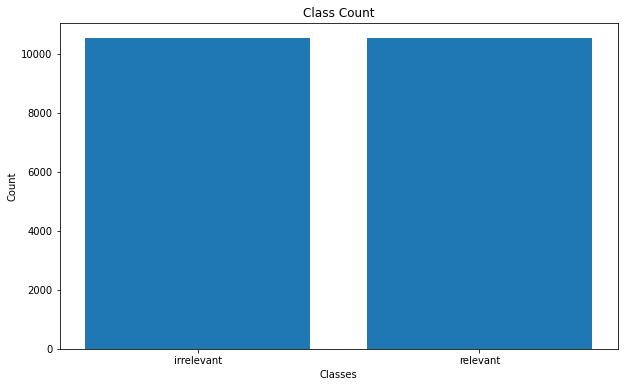

In [13]:
plot_distribution_by_class(trainset_strong, classes)

Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

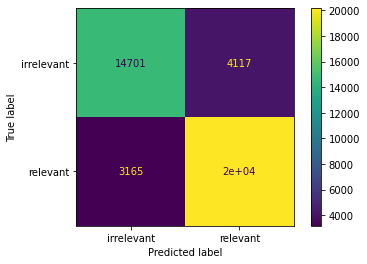

<Figure size 576x432 with 0 Axes>

val Loss: 0.2946 Acc: 0.8735
val Epoch Entropy: 0.4816
val Balanced Accuracy: 1.0000



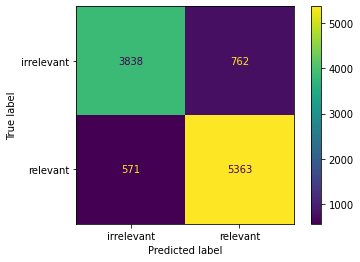

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 1/39
----------
train Loss: 0.3383 Acc: 0.8427
train Epoch Entropy: 0.4805
train Balanced Accuracy: 0.9000



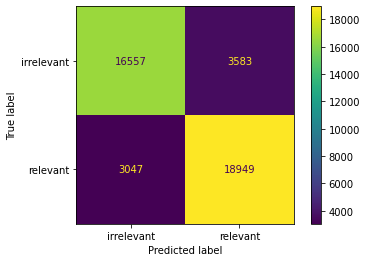

<Figure size 576x432 with 0 Axes>

val Loss: 0.2957 Acc: 0.8727
val Epoch Entropy: 0.4322
val Balanced Accuracy: 0.8750



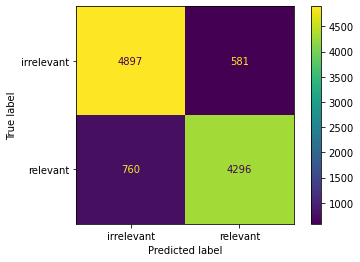

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 2/39
----------
train Loss: 0.3325 Acc: 0.8462
train Epoch Entropy: 0.4706
train Balanced Accuracy: 0.8750



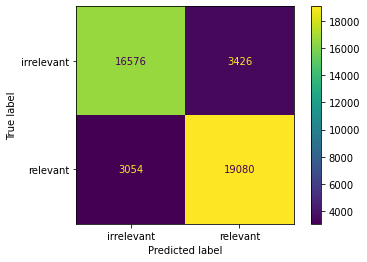

<Figure size 576x432 with 0 Axes>

val Loss: 0.2866 Acc: 0.8755
val Epoch Entropy: 0.4282
val Balanced Accuracy: 0.7500



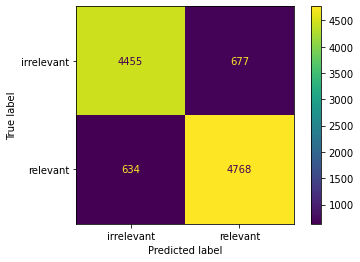

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 3/39
----------
train Loss: 0.3177 Acc: 0.8544
train Epoch Entropy: 0.4555
train Balanced Accuracy: 1.0000



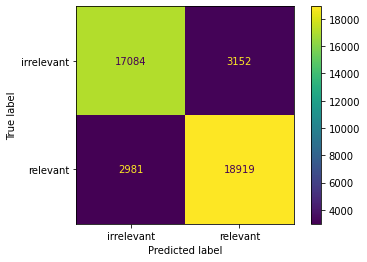

<Figure size 576x432 with 0 Axes>

val Loss: 0.2921 Acc: 0.8742
val Epoch Entropy: 0.4612
val Balanced Accuracy: 1.0000



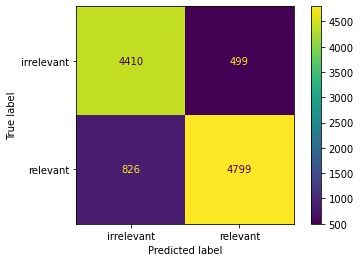

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 4/39
----------
train Loss: 0.3227 Acc: 0.8523
train Epoch Entropy: 0.4593
train Balanced Accuracy: 0.8000



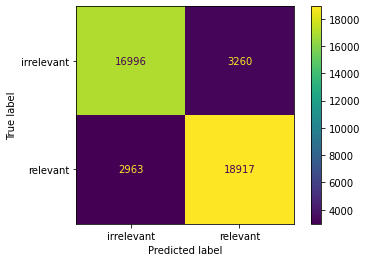

<Figure size 576x432 with 0 Axes>

val Loss: 0.2850 Acc: 0.8825
val Epoch Entropy: 0.4090
val Balanced Accuracy: 0.8333



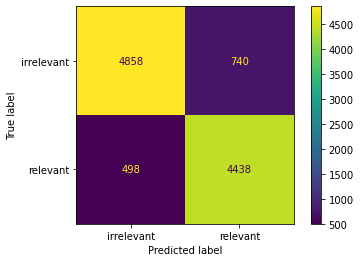

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 5/39
----------
train Loss: 0.3086 Acc: 0.8597
train Epoch Entropy: 0.4465
train Balanced Accuracy: 0.8333



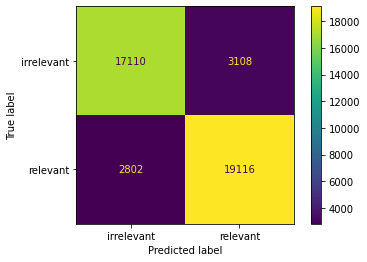

<Figure size 576x432 with 0 Axes>

val Loss: 0.2814 Acc: 0.8787
val Epoch Entropy: 0.4307
val Balanced Accuracy: 1.0000



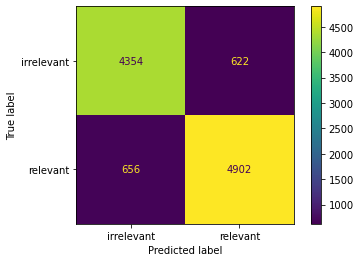

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 6/39
----------
train Loss: 0.3137 Acc: 0.8580
train Epoch Entropy: 0.4533
train Balanced Accuracy: 0.7500



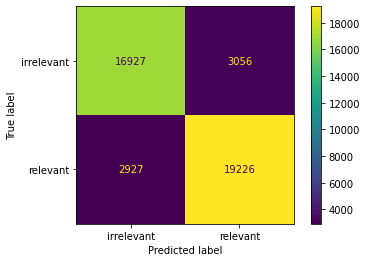

<Figure size 576x432 with 0 Axes>

val Loss: 0.2989 Acc: 0.8703
val Epoch Entropy: 0.4358
val Balanced Accuracy: 0.7500



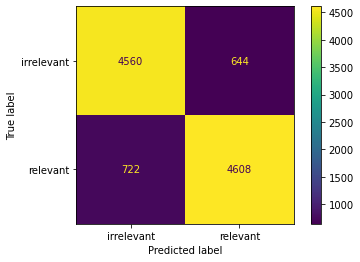

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 7/39
----------
train Loss: 0.2851 Acc: 0.8720
train Epoch Entropy: 0.4339
train Balanced Accuracy: 0.5833



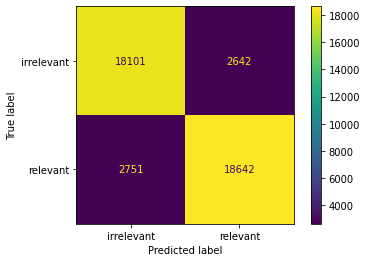

<Figure size 576x432 with 0 Axes>

val Loss: 0.2956 Acc: 0.8689
val Epoch Entropy: 0.4353
val Balanced Accuracy: 1.0000



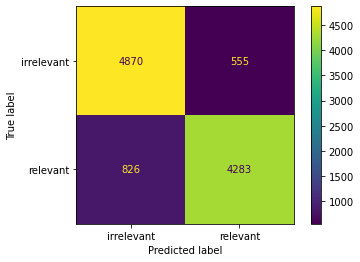

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 8/39
----------
train Loss: 0.2695 Acc: 0.8828
train Epoch Entropy: 0.4124
train Balanced Accuracy: 0.9000



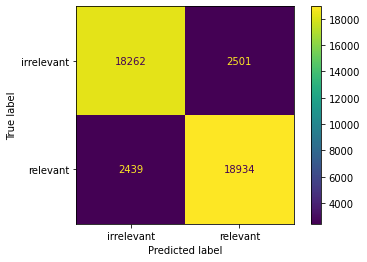

<Figure size 576x432 with 0 Axes>

val Loss: 0.2993 Acc: 0.8699
val Epoch Entropy: 0.4270
val Balanced Accuracy: 0.8750



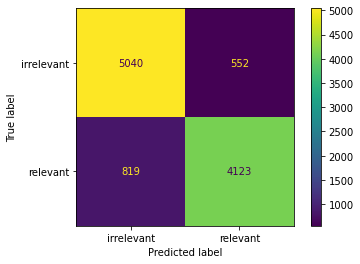

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 9/39
----------
train Loss: 0.2630 Acc: 0.8866
train Epoch Entropy: 0.3993
train Balanced Accuracy: 0.5000



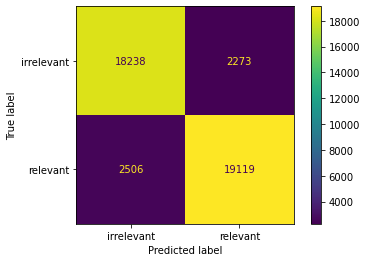

<Figure size 576x432 with 0 Axes>

val Loss: 0.3084 Acc: 0.8713
val Epoch Entropy: 0.3634
val Balanced Accuracy: 0.8333



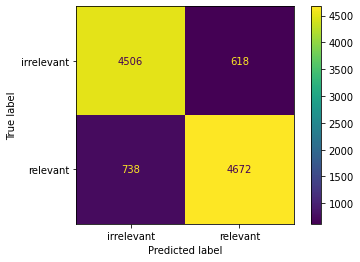

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 10/39
----------
train Loss: 0.2555 Acc: 0.8901
train Epoch Entropy: 0.3868
train Balanced Accuracy: 1.0000



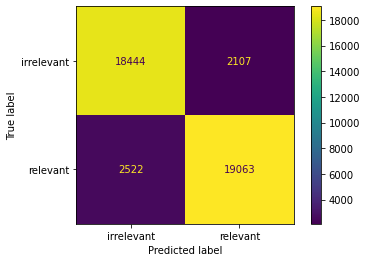

<Figure size 576x432 with 0 Axes>

val Loss: 0.3317 Acc: 0.8727
val Epoch Entropy: 0.3505
val Balanced Accuracy: 0.6667



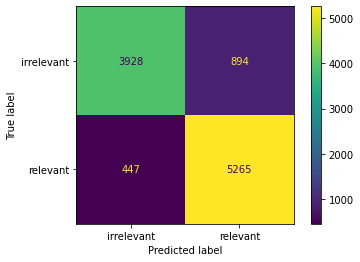

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 11/39
----------
train Loss: 0.2494 Acc: 0.8947
train Epoch Entropy: 0.3779
train Balanced Accuracy: 1.0000



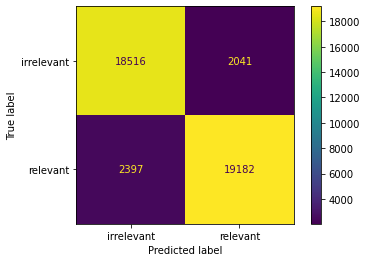

<Figure size 576x432 with 0 Axes>

val Loss: 0.3242 Acc: 0.8718
val Epoch Entropy: 0.3708
val Balanced Accuracy: 1.0000



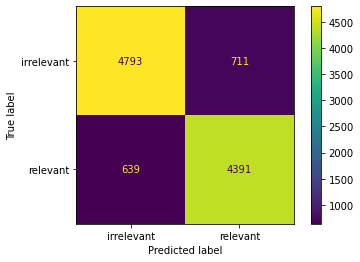

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 12/39
----------
train Loss: 0.2375 Acc: 0.9006
train Epoch Entropy: 0.3634
train Balanced Accuracy: 1.0000



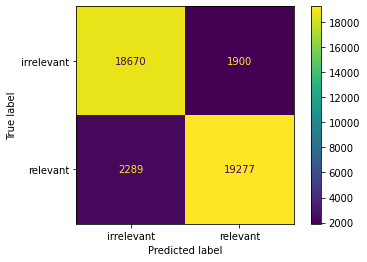

<Figure size 576x432 with 0 Axes>

val Loss: 0.3457 Acc: 0.8701
val Epoch Entropy: 0.3158
val Balanced Accuracy: 0.6667



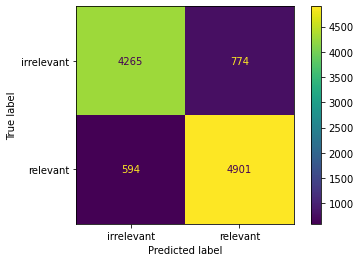

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 13/39
----------
train Loss: 0.2273 Acc: 0.9060
train Epoch Entropy: 0.3501
train Balanced Accuracy: 0.8333



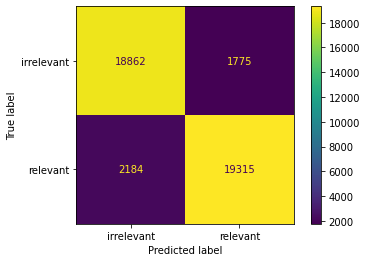

<Figure size 576x432 with 0 Axes>

val Loss: 0.3558 Acc: 0.8641
val Epoch Entropy: 0.3409
val Balanced Accuracy: 1.0000



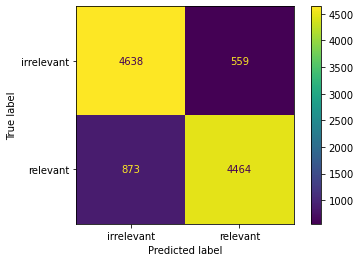

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 14/39
----------
train Loss: 0.2108 Acc: 0.9158
train Epoch Entropy: 0.3406
train Balanced Accuracy: 0.9000



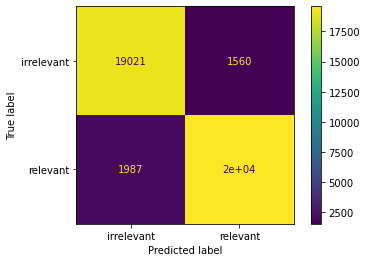

<Figure size 576x432 with 0 Axes>

val Loss: 0.3453 Acc: 0.8664
val Epoch Entropy: 0.3474
val Balanced Accuracy: 0.8333



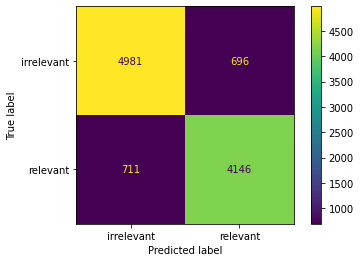

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 15/39
----------
train Loss: 0.2111 Acc: 0.9161
train Epoch Entropy: 0.3363
train Balanced Accuracy: 1.0000



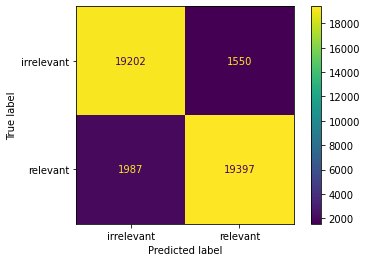

<Figure size 576x432 with 0 Axes>

val Loss: 0.3530 Acc: 0.8647
val Epoch Entropy: 0.3588
val Balanced Accuracy: 0.7500



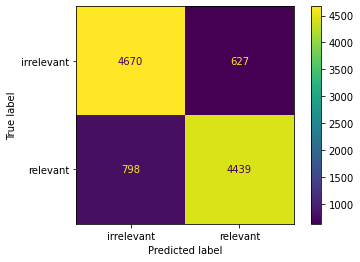

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 16/39
----------
train Loss: 0.2086 Acc: 0.9164
train Epoch Entropy: 0.3324
train Balanced Accuracy: 0.7500



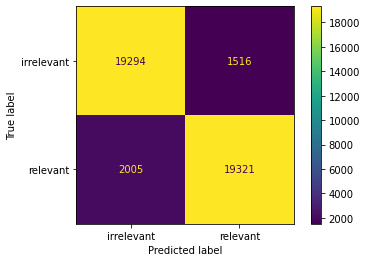

<Figure size 576x432 with 0 Axes>

val Loss: 0.3801 Acc: 0.8698
val Epoch Entropy: 0.3150
val Balanced Accuracy: 1.0000



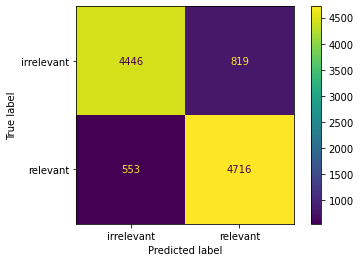

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 17/39
----------
train Loss: 0.2073 Acc: 0.9176
train Epoch Entropy: 0.3318
train Balanced Accuracy: 0.7333



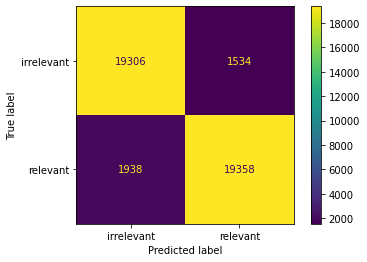

<Figure size 576x432 with 0 Axes>

val Loss: 0.3680 Acc: 0.8673
val Epoch Entropy: 0.3302
val Balanced Accuracy: 0.8750



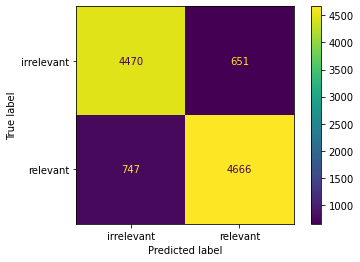

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 18/39
----------
train Loss: 0.2080 Acc: 0.9167
train Epoch Entropy: 0.3299
train Balanced Accuracy: 0.9286



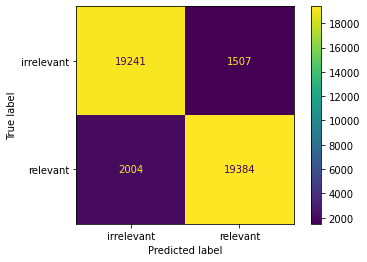

<Figure size 576x432 with 0 Axes>

val Loss: 0.3578 Acc: 0.8615
val Epoch Entropy: 0.3593
val Balanced Accuracy: 1.0000



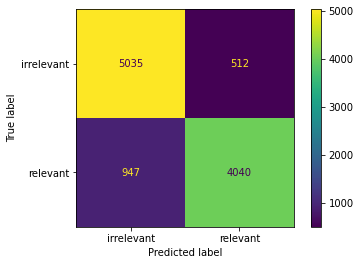

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 19/39
----------
train Loss: 0.2063 Acc: 0.9180
train Epoch Entropy: 0.3291
train Balanced Accuracy: 0.8750



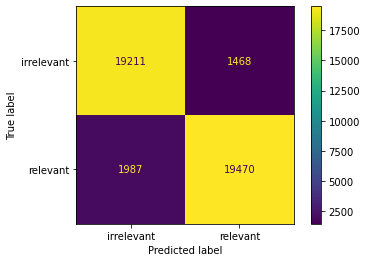

<Figure size 576x432 with 0 Axes>

val Loss: 0.3691 Acc: 0.8669
val Epoch Entropy: 0.3249
val Balanced Accuracy: 0.8750



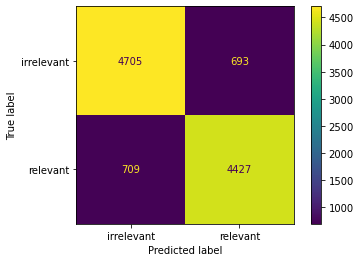

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 20/39
----------
train Loss: 0.2024 Acc: 0.9184
train Epoch Entropy: 0.3281
train Balanced Accuracy: 1.0000



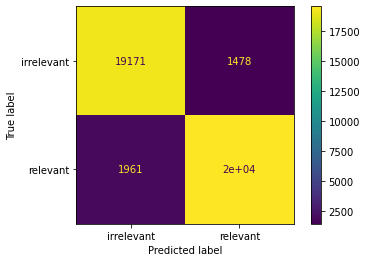

<Figure size 576x432 with 0 Axes>

val Loss: 0.3687 Acc: 0.8668
val Epoch Entropy: 0.3291
val Balanced Accuracy: 0.8000



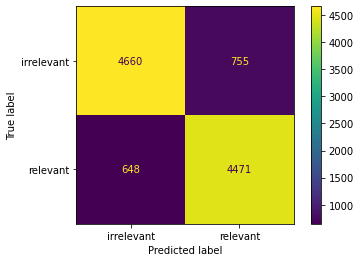

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 21/39
----------
train Loss: 0.2023 Acc: 0.9199
train Epoch Entropy: 0.3263
train Balanced Accuracy: 0.8000



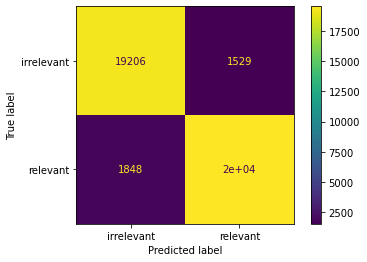

<Figure size 576x432 with 0 Axes>

val Loss: 0.3666 Acc: 0.8658
val Epoch Entropy: 0.3278
val Balanced Accuracy: 1.0000



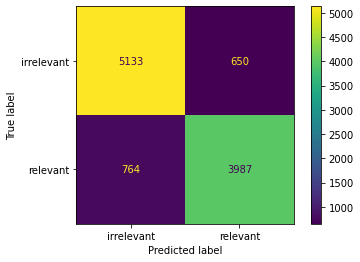

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 22/39
----------
train Loss: 0.2032 Acc: 0.9186
train Epoch Entropy: 0.3248
train Balanced Accuracy: 0.4667



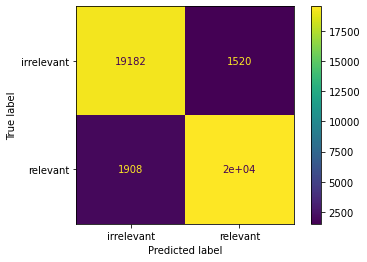

<Figure size 576x432 with 0 Axes>

val Loss: 0.3659 Acc: 0.8667
val Epoch Entropy: 0.3365
val Balanced Accuracy: 1.0000



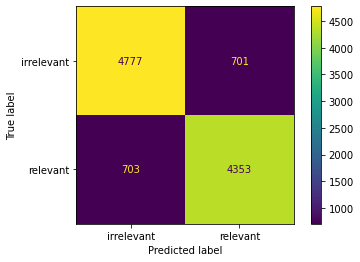

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 23/39
----------
train Loss: 0.2007 Acc: 0.9206
train Epoch Entropy: 0.3264
train Balanced Accuracy: 1.0000



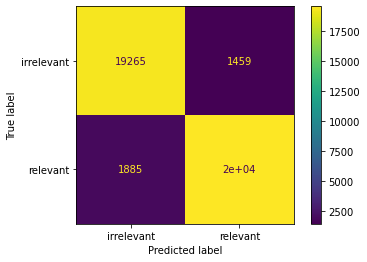

<Figure size 576x432 with 0 Axes>

val Loss: 0.3733 Acc: 0.8672
val Epoch Entropy: 0.3347
val Balanced Accuracy: 0.6250



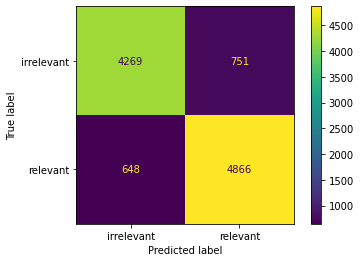

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 24/39
----------
train Loss: 0.1999 Acc: 0.9224
train Epoch Entropy: 0.3251
train Balanced Accuracy: 0.7333



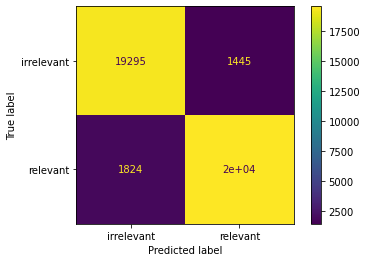

<Figure size 576x432 with 0 Axes>

val Loss: 0.3728 Acc: 0.8678
val Epoch Entropy: 0.3265
val Balanced Accuracy: 0.6667



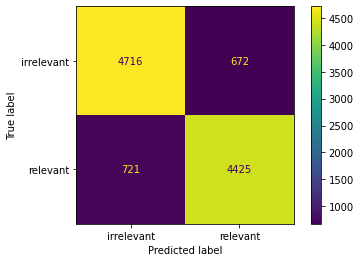

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 25/39
----------
train Loss: 0.2021 Acc: 0.9204
train Epoch Entropy: 0.3253
train Balanced Accuracy: 1.0000



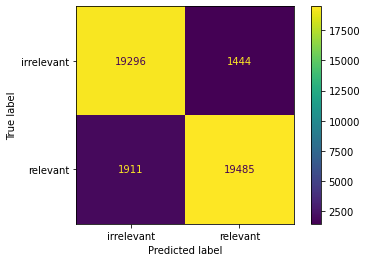

<Figure size 576x432 with 0 Axes>

val Loss: 0.3691 Acc: 0.8671
val Epoch Entropy: 0.3328
val Balanced Accuracy: 0.8750



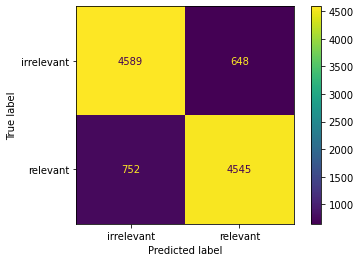

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 26/39
----------
train Loss: 0.1964 Acc: 0.9232
train Epoch Entropy: 0.3231
train Balanced Accuracy: 0.6333



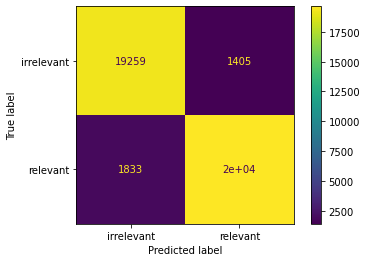

<Figure size 576x432 with 0 Axes>

val Loss: 0.3921 Acc: 0.8675
val Epoch Entropy: 0.3030
val Balanced Accuracy: 0.6667



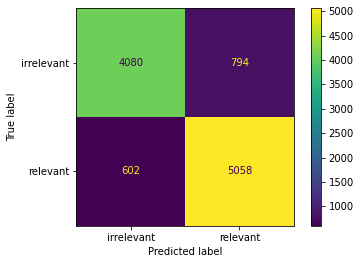

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 27/39
----------
train Loss: 0.1965 Acc: 0.9223
train Epoch Entropy: 0.3221
train Balanced Accuracy: 1.0000



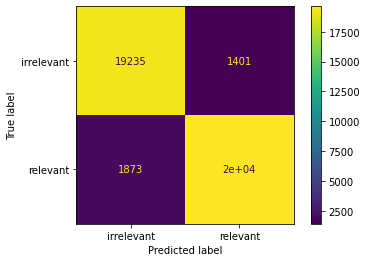

<Figure size 576x432 with 0 Axes>

val Loss: 0.3687 Acc: 0.8671
val Epoch Entropy: 0.3328
val Balanced Accuracy: 0.8333



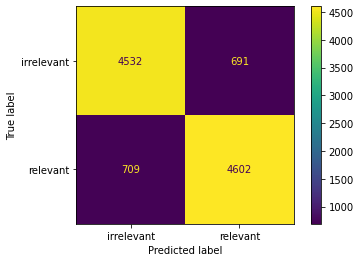

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 28/39
----------
train Loss: 0.2008 Acc: 0.9209
train Epoch Entropy: 0.3244
train Balanced Accuracy: 1.0000



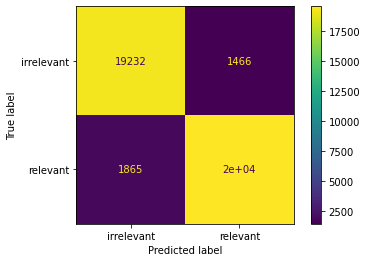

<Figure size 576x432 with 0 Axes>

val Loss: 0.3724 Acc: 0.8668
val Epoch Entropy: 0.3214
val Balanced Accuracy: 0.8000



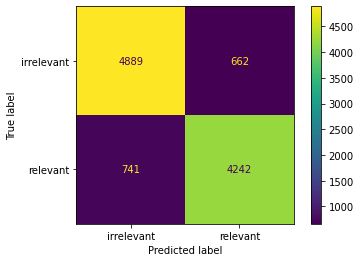

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 29/39
----------
train Loss: 0.2005 Acc: 0.9200
train Epoch Entropy: 0.3216
train Balanced Accuracy: 0.8750



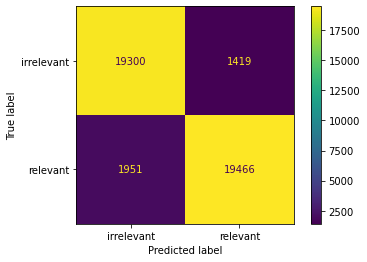

<Figure size 576x432 with 0 Axes>

val Loss: 0.3756 Acc: 0.8629
val Epoch Entropy: 0.3199
val Balanced Accuracy: 1.0000



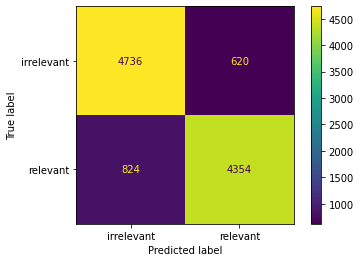

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 30/39
----------
train Loss: 0.2040 Acc: 0.9173
train Epoch Entropy: 0.3251
train Balanced Accuracy: 1.0000



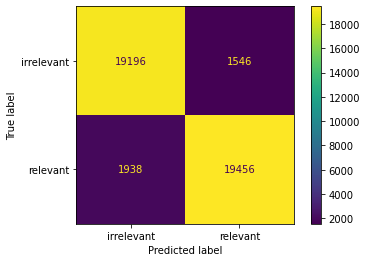

<Figure size 576x432 with 0 Axes>

val Loss: 0.3779 Acc: 0.8674
val Epoch Entropy: 0.3154
val Balanced Accuracy: 0.7500



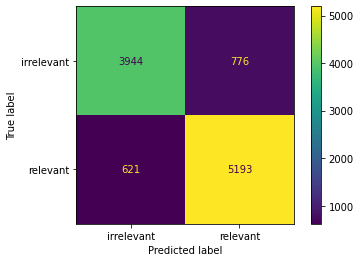

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 31/39
----------
train Loss: 0.1998 Acc: 0.9221
train Epoch Entropy: 0.3242
train Balanced Accuracy: 0.8333



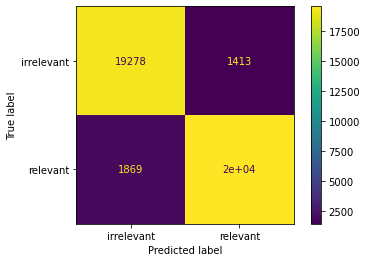

<Figure size 576x432 with 0 Axes>

val Loss: 0.3993 Acc: 0.8673
val Epoch Entropy: 0.2853
val Balanced Accuracy: 0.6667



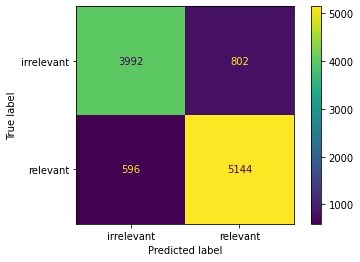

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 32/39
----------
train Loss: 0.1985 Acc: 0.9216
train Epoch Entropy: 0.3219
train Balanced Accuracy: 1.0000



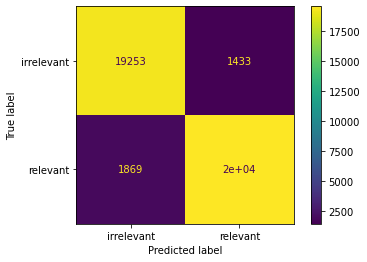

<Figure size 576x432 with 0 Axes>

val Loss: 0.3817 Acc: 0.8675
val Epoch Entropy: 0.3045
val Balanced Accuracy: 0.8333



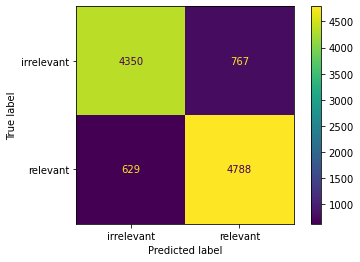

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 33/39
----------
train Loss: 0.1997 Acc: 0.9207
train Epoch Entropy: 0.3230
train Balanced Accuracy: 1.0000



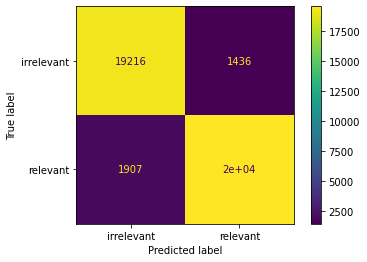

<Figure size 576x432 with 0 Axes>

val Loss: 0.3727 Acc: 0.8680
val Epoch Entropy: 0.3260
val Balanced Accuracy: 0.9000



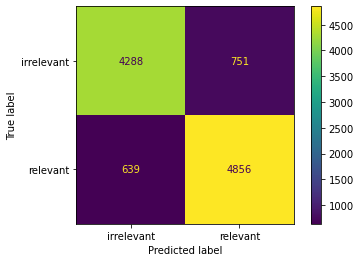

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 34/39
----------
train Loss: 0.1991 Acc: 0.9223
train Epoch Entropy: 0.3243
train Balanced Accuracy: 0.9167



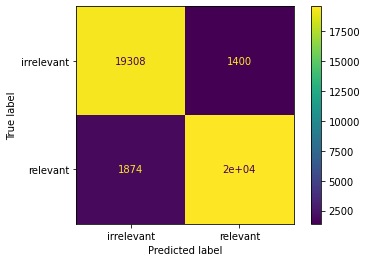

<Figure size 576x432 with 0 Axes>

val Loss: 0.3694 Acc: 0.8642
val Epoch Entropy: 0.3170
val Balanced Accuracy: 1.0000



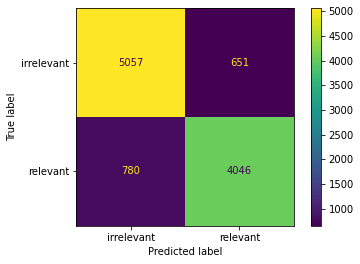

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 35/39
----------
train Loss: 0.2024 Acc: 0.9205
train Epoch Entropy: 0.3250
train Balanced Accuracy: 0.9000



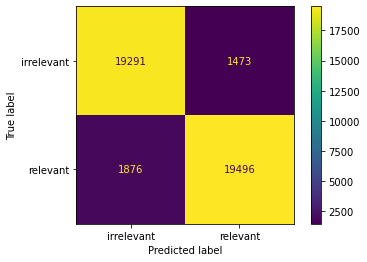

<Figure size 576x432 with 0 Axes>

val Loss: 0.3823 Acc: 0.8679
val Epoch Entropy: 0.3154
val Balanced Accuracy: 1.0000



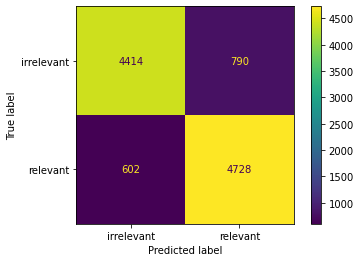

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 36/39
----------
train Loss: 0.1983 Acc: 0.9233
train Epoch Entropy: 0.3239
train Balanced Accuracy: 0.8000



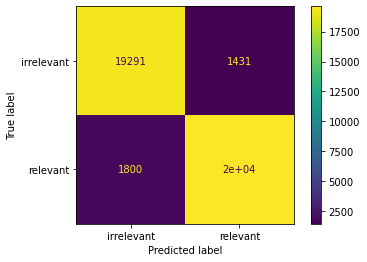

<Figure size 576x432 with 0 Axes>

val Loss: 0.3689 Acc: 0.8659
val Epoch Entropy: 0.3235
val Balanced Accuracy: 1.0000



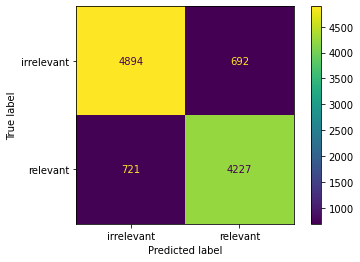

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 37/39
----------
train Loss: 0.2000 Acc: 0.9209
train Epoch Entropy: 0.3241
train Balanced Accuracy: 0.9000



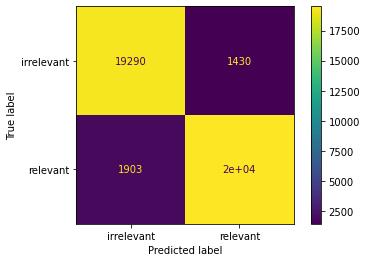

<Figure size 576x432 with 0 Axes>

val Loss: 0.3810 Acc: 0.8679
val Epoch Entropy: 0.3034
val Balanced Accuracy: 1.0000



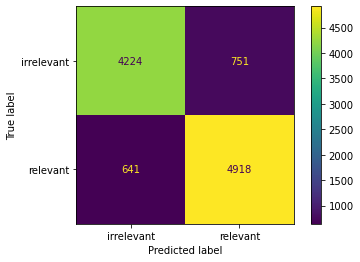

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 38/39
----------
train Loss: 0.2027 Acc: 0.9189
train Epoch Entropy: 0.3242
train Balanced Accuracy: 0.9000



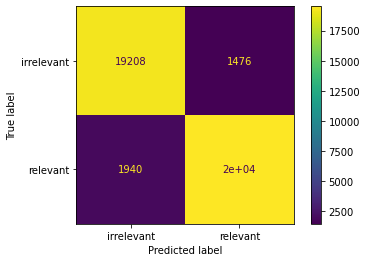

<Figure size 576x432 with 0 Axes>

val Loss: 0.3772 Acc: 0.8684
val Epoch Entropy: 0.3298
val Balanced Accuracy: 0.8750



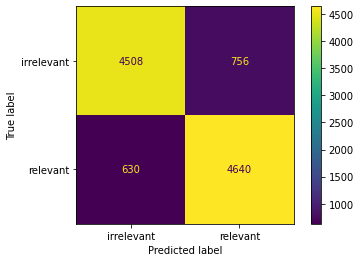

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Epoch 39/39
----------
train Loss: 0.2017 Acc: 0.9202
train Epoch Entropy: 0.3247
train Balanced Accuracy: 1.0000



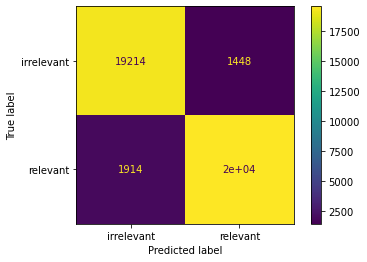

<Figure size 576x432 with 0 Axes>

val Loss: 0.3777 Acc: 0.8687
val Epoch Entropy: 0.3158
val Balanced Accuracy: 0.9000



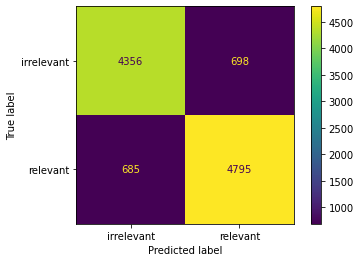

<Figure size 576x432 with 0 Axes>

Number of skipped: 3293

Training complete in 337m 51s
Best val Acc: 0.882476


In [13]:
model_list = []
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset_strong, valset_strong,trainset_weak,valset_weak, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    


The Test Accuracy: tensor(0.6816, device='cuda:0')
The Test Balanced Accuracy: 0.6815834767641996


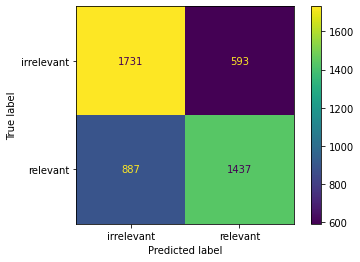

<Figure size 576x432 with 0 Axes>

In [14]:
test_model(model, testset_strong)


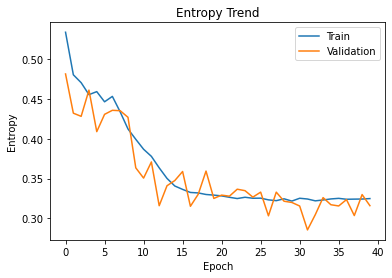

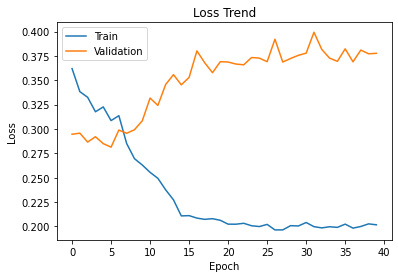

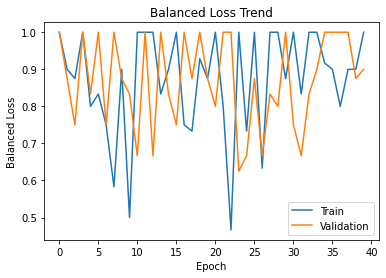

In [15]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [16]:
train_X, train_Y = weighted_score_array(model,model_list, trainset_strong, trainset_weak)
test_X, test_Y = weighted_score_array(model,model_list, testset_strong, testset_strong)


In [17]:

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.5006454388984509


Accuracy for SVM: 0.8368115318416524
Balanced Accuracy:0.8336386336774879


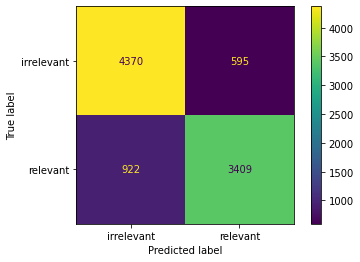

<Figure size 576x432 with 0 Axes>

In [18]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.8374569707401033
Balanced Accuracy:0.8343902817296694


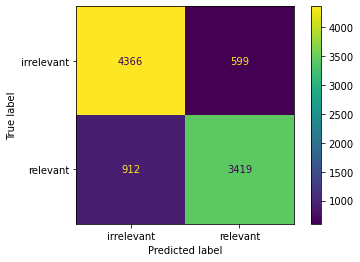

<Figure size 576x432 with 0 Axes>

In [19]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()